# Question 4: Backtesting

Objective: \
Demonstrate understanding of how to implement and backtest a trading strategy.

Backtest either: \
RSI or MACD strategies .
Show PnL, annualised sharpe ratio, and drawdown over time.
Make your code as effieicent (vectorized) as possible.

In [158]:
import os
from datetime import timedelta
import sqlite3
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = f'{os.pardir}/data/MarketData.csv'

metals = ['COPPER', 'ZINC']

In [159]:
# Get the data from the database
def log_execution(func):
    def wrapper(*args, **kwargs):
        if func.__name__=='get_metal_data':
            print(f"Getting data for {args[0]} from {args[1]} to {args[2]}.")
        else:
            print(f"Running function {func.__name__} with arguments: {args} and keyword arguments: {kwargs}.")
        start_execution = time.time()
        result = func(*args, **kwargs)
        end_execution = time.time()
        print(f"Finished execution of {func.__name__} in {end_execution - start_execution:.2f} seconds.\n")
        return result
    return wrapper

@log_execution
def get_metal_data(metal, start_date, end_date):
    conn = sqlite3.connect(f'{os.pardir}/market_data.db')
    cur = conn.cursor()
    cur.execute('''
        SELECT * FROM MetalPrices
        WHERE Metal = ? AND Date >= ? AND Date <= ?
        ORDER BY Date
    ''', (metal, start_date, end_date))

    df = pd.DataFrame(cur.fetchall(), columns=['Date', 'Metal', 'Price', 'MACD', 'RSI'])
    cur.close()
    conn.close()
    df['Date'] = pd.to_datetime(df['Date'])
    return df

start_date = '2020-01-01'
end_date = '2021-12-31'
df = get_metal_data('COPPER', start_date, end_date)
df

Getting data for COPPER from 2020-01-01 to 2021-12-31.
Finished execution of get_metal_data in 0.01 seconds.



,Date,Metal,Price,MACD,RSI
0,2020-01-01,COPPER,6174.0,69.634394,62.254143
1,2020-01-02,COPPER,6188.0,65.324212,63.811455
2,2020-01-03,COPPER,6129.5,56.536187,53.862378
3,2020-01-06,COPPER,6138.5,49.724644,55.018407
4,2020-01-07,COPPER,6149.0,44.658909,56.384452
...,...,...,...,...,...
518,2021-12-27,COPPER,9568.0,-2.500190,51.494312
519,2021-12-28,COPPER,9568.0,0.815513,51.494312
520,2021-12-29,COPPER,9680.5,12.378352,56.027452
521,2021-12-30,COPPER,9691.5,22.173985,56.453796


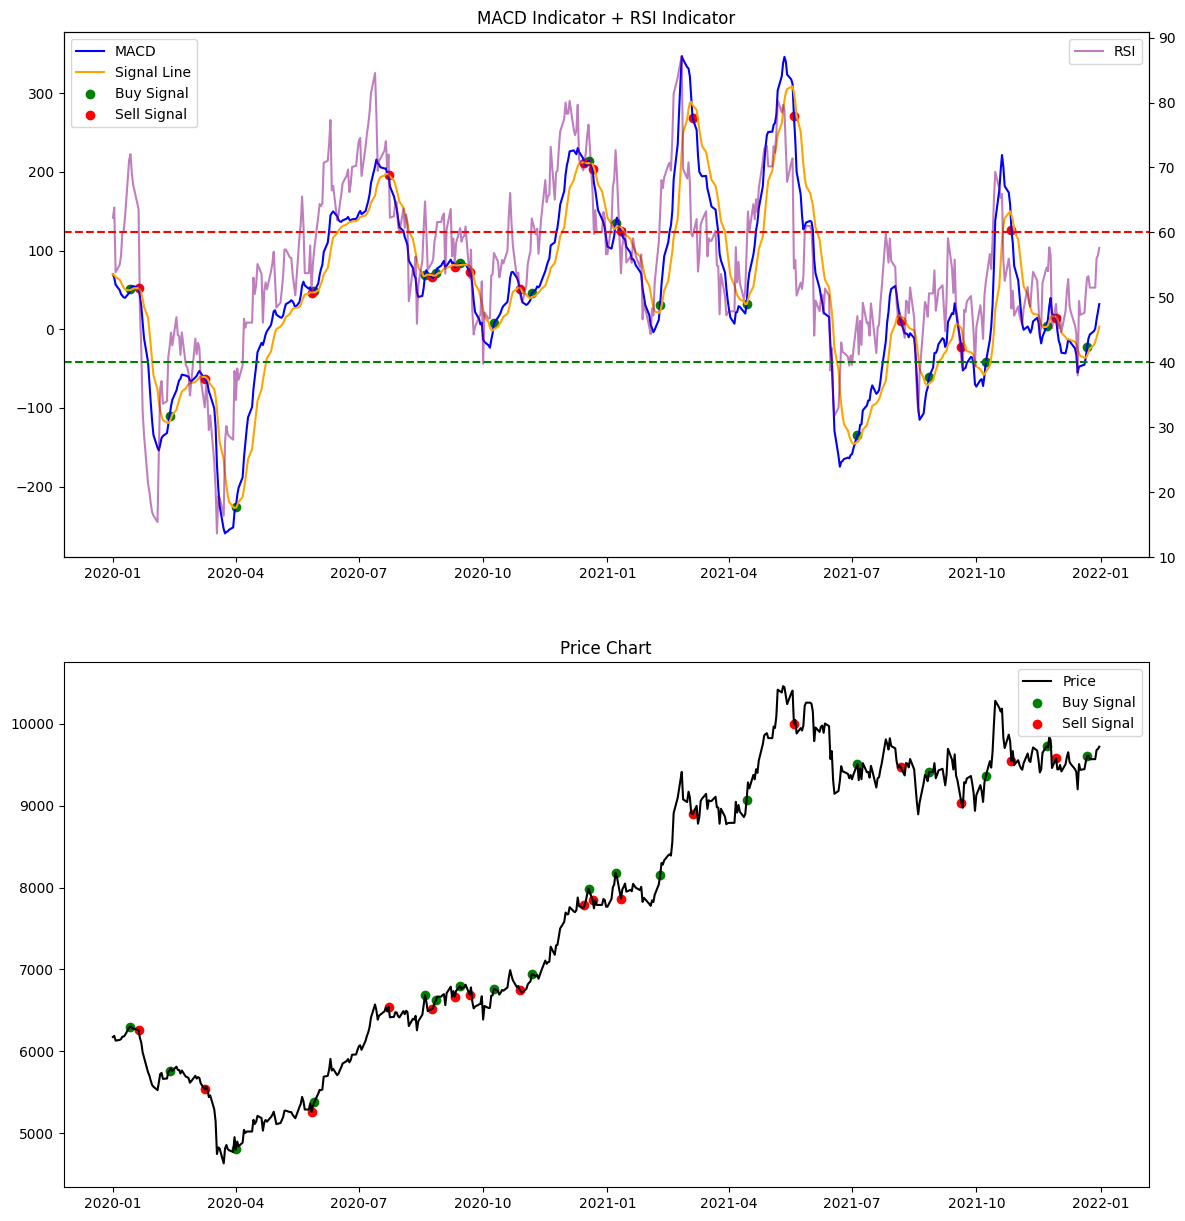

In [160]:
fig = plt.figure(figsize=(14, 15))
grid = fig.add_gridspec(nrows=2, ncols=1)

ax = fig.add_subplot(grid[0, 0])

ax.plot(df['Date'], df['MACD'], label='MACD', color='blue')
signal = df['MACD'].ewm(span=9, adjust=False).mean()
ax.plot(df['Date'], signal, label='Signal Line', color='orange')
mask_MACD_above_signal = df['MACD'] > signal
mask_MACD_corsses_signal = mask_MACD_above_signal.astype(int).diff()
ax.scatter(df['Date'][mask_MACD_corsses_signal>0], df['MACD'][mask_MACD_corsses_signal>0], color='green', label='Buy Signal')
ax.scatter(df['Date'][mask_MACD_corsses_signal<0], df['MACD'][mask_MACD_corsses_signal<0], color='red', label='Sell Signal')
ax.legend(loc='upper left')
ax = ax.twinx()
ax.plot(df['Date'], df['RSI'], label='RSI', color='purple', alpha=0.5)
ax.axhline(60, color='red', linestyle='--')
ax.axhline(40, color='green', linestyle='--')
ax.legend(loc='upper right')
ax.set_title('MACD Indicator + RSI Indicator')

ax = fig.add_subplot(grid[1, 0])
ax.plot(df['Date'], df['Price'], label='Price', color='black')
ax.scatter(df['Date'][mask_MACD_corsses_signal>0], df['Price'][mask_MACD_corsses_signal>0], color='green', label='Buy Signal')
ax.scatter(df['Date'][mask_MACD_corsses_signal<0], df['Price'][mask_MACD_corsses_signal<0], color='red', label='Sell Signal')
ax.legend()
ax.set_title('Price Chart')

plt.show()

In [161]:
# Test a strategy 
# def backtest_strategy(df):
"""Buy if MACD crosses above signal line and RSI < 40, sell if MACD crosses below signal line and RSI > 60."""
signal = df['MACD'].ewm(span=9, adjust=False).mean()
MACD_crosses_signal = (df['MACD'] > signal).astype(int).diff().fillna(0)

# Save a dataframe with the history of the simulation
hist_free_capital, hist_held_positions, hist_invested_value = [], [], [] 
# Save a dataframe with the info of each trade
hist_entry_dates, hist_exit_dates, hist_entry_prices, hist_exit_prices = [], [], [], []
# Initial values for the simulation
free_capital, held_positions, invested_value = 10000, 0, 0 
for idx in df.index:
    # Buy
    if (MACD_crosses_signal[idx] > 0):
        # TODO: check non-negative value
        # Simulation values
        held_positions += 1
        free_capital -= df['Price'][idx]
        invested_value += df['Price'][idx]
        # Trade values
        hist_entry_dates.append(df['Date'][idx])
        hist_entry_prices.append(df['Price'][idx])

    # Sell
    elif (held_positions > 0) & (MACD_crosses_signal[idx] < 0):
        # Trades values
        for p in np.arange(held_positions):
            hist_exit_dates.append(df['Date'][idx])
            hist_exit_prices.append(df['Price'][idx])
        # Simulation values
        free_capital += df['Price'][idx] * held_positions
        held_positions = 0
        invested_value = 0

    # Hold 
    else:
        invested_value = df['Price'][idx] * held_positions
        # free_capital = free_capital
        # held_positions = held_positions

    # Update portfolio value
    hist_free_capital.append(free_capital)
    hist_held_positions.append(held_positions)
    hist_invested_value.append(invested_value) 

# Save the simulation results
df_simulation = pd.DataFrame({
    'Date': df['Date'],
    'Price': df['Price'],
    'Free Capital': hist_free_capital,
    'Held Positions': hist_held_positions,
    'Invested Capital': hist_invested_value
})

# If a trade was entered before the end of the simulation, remove it
if held_positions > 0:
    # From the last entry date to the end of the simulation update the Free Capital, Held Positions and Invested Capital
    date = hist_entry_dates[-held_positions]
    idx = df_simulation[df_simulation['Date'] == date].index[0]
    df_simulation.loc[idx:, ['Free Capital', 'Held Positions', 'Invested Capital']] = [
        df_simulation.loc[idx - 1, 'Free Capital'], 0, 0
    ]
    # Remove the last entry dates and and prices that were not closed
    hist_entry_dates = hist_entry_dates[:-held_positions]
    hist_entry_prices = hist_entry_prices[:-held_positions]

df_trades = pd.DataFrame({
    'Entry Date': hist_entry_dates,
    'Exit Date': hist_exit_dates,
    'Entry Price': hist_entry_prices,
    'Exit Price': hist_exit_prices
})
df_trades['Profit'] = df_trades['Exit Price'] - df_trades['Entry Price']

print('Simulation results:')
print(df_simulation[:5])
print('\nTrades results:')
print(df_trades[:5])

Simulation results:
        Date   Price  Free Capital  Held Positions  Invested Capital
0 2020-01-01  6174.0       10000.0               0               0.0
1 2020-01-02  6188.0       10000.0               0               0.0
2 2020-01-03  6129.5       10000.0               0               0.0
3 2020-01-06  6138.5       10000.0               0               0.0
4 2020-01-07  6149.0       10000.0               0               0.0

Trades results:
  Entry Date  Exit Date  Entry Price  Exit Price  Profit
0 2020-01-14 2020-01-20       6302.0      6259.0   -43.0
1 2020-02-12 2020-03-09       5764.0      5535.0  -229.0
2 2020-04-01 2020-05-27       4800.0      5259.5   459.5
3 2020-05-29 2020-07-23       5376.5      6544.5  1168.0
4 2020-08-19 2020-08-24       6685.0      6516.0  -169.0


In [185]:
# Add performance metrics

def calculate_daily_returns(df):
    """Calculate daily returns of the portfolio based on Free Capital and Invested Capital combined.
    INPUT:
        df: DataFrame of the simulation with columns 'Free Capital' and 'Invested Capital'.
    """
    portfolio_value = df['Free Capital'] + df['Invested Capital']
    df['Daily Returns'] = portfolio_value.pct_change().fillna(0)

def calculate_PnL(df):
    """Calculate profit and loss (PnL) of the portfolio for the whole simulation.
    INPUT:
        df: DataFrame of the trades with column 'Profit'.
    """
    n_profitable_trades = len(df[df['Profit'] > 0])
    n_loss_trades = len(df[df['Profit'] < 0])
    total_profit = df[df['Profit'] > 0]['Profit'].sum()
    total_loss = -df[df['Profit'] < 0]['Profit'].sum()
    PnL = (total_profit/n_profitable_trades) / (total_loss/n_loss_trades)
    return PnL

def calculate_perc_profitable_trades(df):
    """Calculate the percentage of profitable trades.
    INPUT:
        df: DataFrame of the trades with column 'Profit'.
    """
    n_profitable_trades = len(df[df['Profit'] > 0])
    n_loss_trades = len(df[df['Profit'] < 0])
    perc_profitable_trades = n_profitable_trades / (n_profitable_trades + n_loss_trades)
    return perc_profitable_trades

def calculate_sharpe_ratio(df):
    """Calculate the Sharpe ratio.
    INPUT:
        df: DataFrame of the simulation with column 'Daily Returns'.
    """
    avg_daily_returns = df['Daily Returns'].mean()
    std_daily_returns = df['Daily Returns'].std()
    sharpe_ratio  = (avg_daily_returns / std_daily_returns) * np.sqrt(252)
    return sharpe_ratio

def calculate_drawdown(df):
    """Calculate the drawdown of the portfolio over time (percentage).
    INPUT:
        df: DataFrame of the simulation with column 'Free Capital' and 'Invested Capital'.
    """
    portfolio_value = df['Free Capital'] + df['Invested Capital']
    rolling_max = portfolio_value.cummax()
    df['Drawdown'] = ((portfolio_value - rolling_max) / rolling_max) * 100

def calculate_max_drawdown(df):
    """Returns the maximum drawdown of the portfolio over time (percentage).
    INPUT:
        df: DataFrame of the simulation with column 'Drawdown'.
    """
    max_drawdown = df['Drawdown'].min()
    return max_drawdown

# Add some performance metrics to the simulation DataFrame
calculate_daily_returns(df_simulation)
calculate_drawdown(df_simulation)

# Periods to evaluate
periods = [
    ('2020-01-01', '2020-12-31'),
    ('2021-01-01', '2021-12-31'),
    ('2020-01-01', '2021-12-31')
]
PnLs, sharpe_ratios, max_drawdowns, perc_profitable_trades = [], [], [], []
# Calculate the performance metrics for each period
for start_date, end_date in periods:
    # Select the data for a period
    sel_df_simulation = df_simulation[(df_simulation['Date'] >= start_date) & (df_simulation['Date'] <= end_date)]
    sel_df_trades = df_trades[(df_trades['Entry Date'] >= start_date) & (df_trades['Exit Date'] <= end_date)]
    # Calculate the performance metrics
    PnLs.append(calculate_PnL(sel_df_trades))
    sharpe_ratios.append(calculate_sharpe_ratio(sel_df_simulation))
    max_drawdowns.append(calculate_max_drawdown(sel_df_simulation))
    perc_profitable_trades.append(calculate_perc_profitable_trades(sel_df_trades))

# Create a DataFrame with the performance metrics
performance_metrics = pd.DataFrame({
    'Period': [f'{start} - {end}' for start, end in periods],
    'PnL': PnLs,
    'Sharpe Ratio': sharpe_ratios,
    'Max Drawdown (%)': max_drawdowns,
    'Profitable Trades (%)': perc_profitable_trades,
})
print('\nPerformance metrics:')
performance_metrics


Performance metrics:


,Period,PnL,Sharpe Ratio,Max Drawdown (%),Profitable Trades (%)
0,2020-01-01 - 2020-12-31,5.388412,2.062819,-2.890529,0.400000
1,2021-01-01 - 2021-12-31,2.808446,0.701482,-7.310562,0.428571
2,2020-01-01 - 2021-12-31,3.946395,1.220547,-7.310562,0.411765
